In [1]:
import numpy as np
from copy import deepcopy
import random, math, sys
from scipy.spatial.distance import pdist, squareform
from numpy import exp
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:

totalData =569
df = pd.read_csv("train-data.csv")


df.drop(['id'], axis = 1, inplace = True)
df.head()


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,19.772,11.336,134.599,1096.771,0.067,0.326,0.385,0.221,0.217,0.099,...,19.029,202.212,2211.972,0.212,0.737,0.781,0.287,0.466,0.133,0
1,22.601,19.453,145.467,1452.768,0.099,0.052,0.042,0.151,0.191,0.140,...,25.600,173.949,2143.103,0.137,0.282,0.311,0.184,0.302,0.196,0
2,21.507,23.214,142.380,1317.998,0.111,0.266,0.241,0.197,0.166,0.081,...,28.073,167.074,1872.370,0.119,0.395,0.459,0.300,0.361,0.126,0
3,12.505,22.374,85.098,423.055,0.275,0.252,0.280,0.107,0.250,0.120,...,28.946,108.286,622.059,0.168,0.971,0.728,0.266,0.737,0.349,0
4,22.227,15.690,148.024,1420.916,-0.032,0.261,0.230,0.120,0.120,0.087,...,18.287,166.754,1725.556,0.161,0.234,0.464,0.336,0.218,0.107,0


In [3]:
columns_with_na = df.columns[df.isna().any()].tolist()

In [4]:
for col_name in columns_with_na:
    df[col_name].fillna(df[col_name].median(), inplace=True)


In [5]:
array = df.values
X_data = array[:,1:]
Y=array[:,30:]


In [6]:
# split our data into training and validation sets (since we already have a separate test set)

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df['diagnosis'], train_size=0.8, test_size=0.2,
                                                  random_state=120)

In [7]:
df['diagnosis'].value_counts(normalize=True) * 100

1    62.741652
0    37.258348
Name: diagnosis, dtype: float64

In [8]:
# Normalize the featues

from sklearn.preprocessing import Normalizer

norm = Normalizer()
norm.fit(X_train)
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components = 1)
X_LDA = lda.fit_transform(X_data, Y)
X_val = lda.transform(X_test)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_LDA, Y, random_state=1)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
confusion_matrix=confusion_matrix(y_test, y_pred)
print(confusion_matrix)

print('Accuracy -> ' + str(accuracy_score(y_test, y_pred)))

[[52  3]
 [ 7 81]]
Accuracy -> 0.9300699300699301


In [11]:
z=df.loc[:,['diagnosis']].values
print(len(z))



569


In [12]:
def gaussianKernel(gamma, distance):
    return np.exp(-gamma * distance)

def polykernel(X):
    K = np.zeros(shape=(len(X), len(X)))
    for i in range(len(X)):
        for j in range(len(X)):
            k = 1 + np.dot(X[i].T,X[j]) 
            k = math.pow(k, 3)
            K[i][j] = k
    return K

def linear(X):
    K = np.zeros(shape=(len(X), len(X)))
    for i in range(len(X)):
        for j in range(len(X)):
            k = 1 + np.dot(X[i].T,X[j]) 
            k = math.pow(k, 1)
            K[i][j] = k
    return K

In [17]:
def kernellda(X, gamma,z):
    target_label=z
    data=X
    print(data[0][0])
    print(data.shape)
    labels = []
    class1 = 0
    class2 = 0
    for i in range(totalData):
        label = int(z[i])
        if label ==1:
            class1 += 1
        else: class2 += 1
        labels.append(label)

    D = pdist(data, 'sqeuclidean')
    A = squareform(D)
    kernel = exp(-gamma * A)
    B = np.ones((totalData, totalData)) / totalData
    
    kernel = kernel - B.dot(kernel) - kernel.dot(B) + B.dot(kernel).dot(B)
    Mat1 = np.zeros((totalData, class1))
    Mat1 = np.zeros((totalData, class2))
    for i in range(totalData):
        c1 = 0
        c2 = 0
        for j in range(30):
            if labels[j] == 1:
                
                Mat1[i][c1] = data[i][j]
                c1 += 1
            else:
                
                Mat2[i][c2] = data[i][j]
                c2 += 1
                
    C = np.ones((class1, class1))/class1
    D = np.ones((class2, class2))/class2
    N = Mat1.dot(np.identity(class1) - C).dot(Mat1.T) + Mat2.dot(np.identity(class2) - D).dot(Mat2.T)
    N = N + (np.identity(totalData) * 0)
    
    #between class M
    M1 = np.zeros((totalData, 1))
    M2 = np.zeros((totalData, 1))
    
    for i in range(totalData):
        sum1 = 0
        sum2 = 0
        for j in range(class1):
            sum1 += K1[i][j]
        for j in range(class2):
            sum2 += K2[i][j]
        M1[i] = float(sum1)/class1
        M2[i] = float(sum2)/class2
    res = np.linalg.inv(N).dot(M2 - M1)
    return res, kernel

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df['diagnosis'], train_size=0.8, test_size=0.2,random_state=120)
projection, kernel = kernellda(X_data,2100,z)
newdata = kernel.dot(projection)



11.335999999999999
(569, 30)


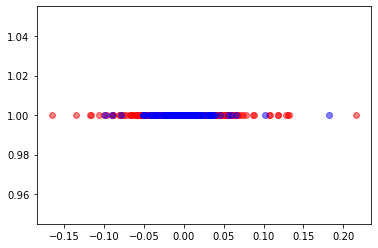

In [19]:
labels=[]
for i in range(totalData):
        label = int(z[i])
        labels.append(label)
plt.scatter([newdata[i][0] for i in range(len(newdata)) if labels[i] == 1], [1 for i in range(len(newdata)) if labels[i] == 1], color='red', alpha=0.5)
plt.scatter([newdata[i][0] for i in range(len(newdata)) if labels[i] == 0], [1 for i in range(len(newdata)) if labels[i] == 0], color='blue', alpha=0.5)
plt.show()
  

In [20]:
X_train, X_test, y_train, y_test = train_test_split(newdata, Y, random_state=1)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
#confusion_matrix1=confusion_matrix(y_test, y_pred)
#print(confusion_matrix1)

print('Accuracy -> ' + str(accuracy_score(y_test, y_pred)))

Accuracy -> 0.6153846153846154


In [21]:
data_new=pd.DataFrame(newdata)
data_new['class']=z
data_new.columns=["LD1","class"]
data_new.head()

,LD1,class
0,-0.049179,0
1,0.023098,0
2,-0.002012,0
3,-0.023440,0
4,-0.051169,0


In [22]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(newdata, Y, random_state=1)
clf = RandomForestClassifier(max_depth = 2, random_state = 0)
clf.fit(X_train, y_train)

# Predicting the Test set results
y_pred = clf.predict(X_test)

<ipython-input-22-d965ae6bd44c>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy -> '+ str(accuracy_score(y_test, y_pred)))

[[38 17]
 [33 55]]
Accuracy -> 0.6503496503496503


11.335999999999999
(569, 30)


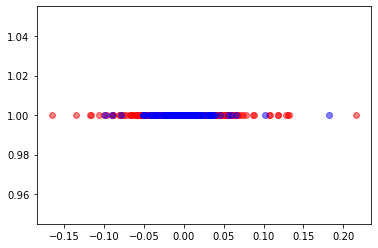

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df['diagnosis'], train_size=0.8, test_size=0.2,random_state=120)
projection, kernel = kernellda(X_data,100,z)
newdata = kernel.dot(projection)

labels=[]
for i in range(totalData):
        label = int(z[i])
        labels.append(label)
plt.scatter([newdata[i][0] for i in range(len(newdata)) if labels[i] == 1], [1 for i in range(len(newdata)) if labels[i] == 1], color='red', alpha=0.5)
plt.scatter([newdata[i][0] for i in range(len(newdata)) if labels[i] == 0], [1 for i in range(len(newdata)) if labels[i] == 0], color='blue', alpha=0.5)
plt.show()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(newdata, Y, random_state=1)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
#confusion_matrix1=confusion_matrix(y_test, y_pred)
#print(confusion_matrix1)

print('Accuracy -> ' + str(accuracy_score(y_test, y_pred)))

Accuracy -> 0.6153846153846154


In [26]:
data_new=pd.DataFrame(newdata)
data_new['class']=z
data_new.columns=["LD1","class"]
data_new.head()

,LD1,class
0,-0.049179,0
1,0.023098,0
2,-0.002012,0
3,-0.023440,0
4,-0.051169,0


In [27]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(newdata, Y, random_state=1)
clf = RandomForestClassifier(max_depth = 2, random_state = 0)
clf.fit(X_train, y_train)

# Predicting the Test set results
y_pred = clf.predict(X_test)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy -> '+ str(accuracy_score(y_test, y_pred)))

[[38 17]
 [33 55]]
Accuracy -> 0.6503496503496503


<ipython-input-27-8f6a259d3fe6>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)
